In [2]:
# installing yahoo finance library
!pip install yfinance


In [3]:
# We are importing all necessary libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [4]:
# importing USD-JPY data from yahoo finance
usd_jpy_df = yf.download('USDJPY=X', start='1996-10-30', end='2024-08-29')
usd_jpy_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0


In [5]:
# From here we can see that on average yen value was 111.59, and it was min 75.73 per usd, highest was 161.62
usd_jpy_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7218.000000,7218.000000,7218.000000,7218.000000,7218.000000,7218.0
mean,111.594651,112.050878,111.095597,111.589815,111.589815,0.0
std,16.040874,16.123239,15.955976,16.040775,16.040775,0.0
min,75.750000,75.973999,75.570000,75.739998,75.739998,0.0
25%,104.322500,104.806999,103.900501,104.316002,104.316002,0.0
50%,110.992496,111.407001,110.586502,110.999500,110.999500,0.0
75%,119.856001,120.349998,119.297503,119.848000,119.848000,0.0
max,161.621002,161.942001,161.300003,161.621002,161.621002,0.0


In [6]:
# We can see that there are no null values
usd_jpy_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'Yen/USD over years')

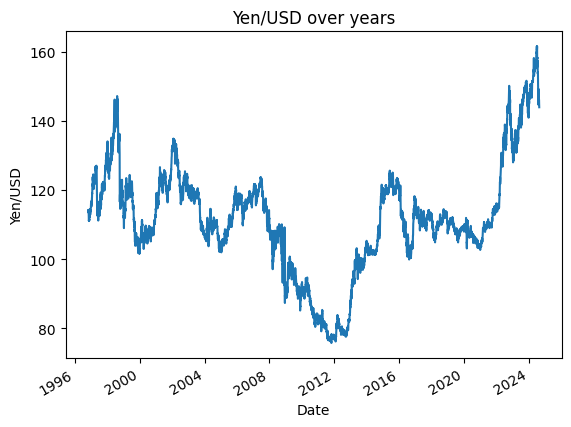

In [7]:
# Here we can see value of  Yen/USD over time
usd_jpy_df['Adj Close'].plot()
plt.ylabel('Yen/USD')
plt.title('Yen/USD over years')

In [8]:
# Our data is not stationary because p is not significant
from statsmodels.tsa.stattools import adfuller

adfuller(usd_jpy_df['Close'])[1]  # p-value

0.5522395324429307

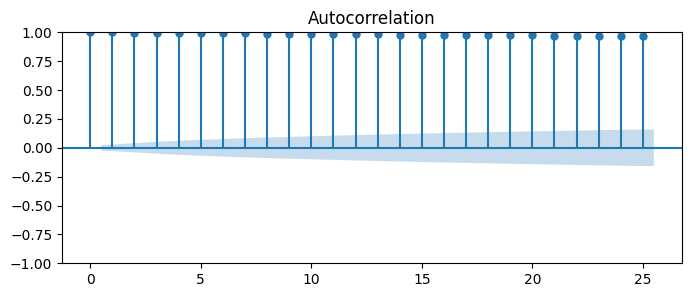

In [9]:
# We can see that autocorrelation until lags 25
fig, ax = plt.subplots(1,1, figsize=(8,3))
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(usd_jpy_df['Close'], lags=25, ax=ax)
plt.show()

In [10]:
# Let's also add columns as Day of week, Month, year
usd_jpy_df['Day_of_week'] = usd_jpy_df.index.dayofweek
usd_jpy_df['Month'] = usd_jpy_df.index.month
usd_jpy_df['Year'] = usd_jpy_df.index.year
usd_jpy_df.head()


,Open,High,Low,Close,Adj Close,Volume,Day_of_week,Month,Year
Date,,,,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0,2,10,1996
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0,4,11,1996
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0,0,11,1996
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0,1,11,1996
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0,2,11,1996


Text(0, 0.5, 'USD/Yen')

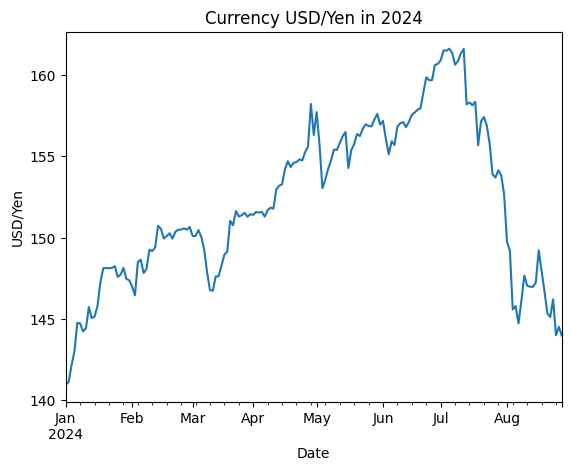

In [11]:
#From here we can see fluctuation of usd/yen in 2024
usd_jpy_df[usd_jpy_df['Year']==2024]['Close'].plot()
plt.title('Currency USD/Yen in 2024')
plt.ylabel('USD/Yen')

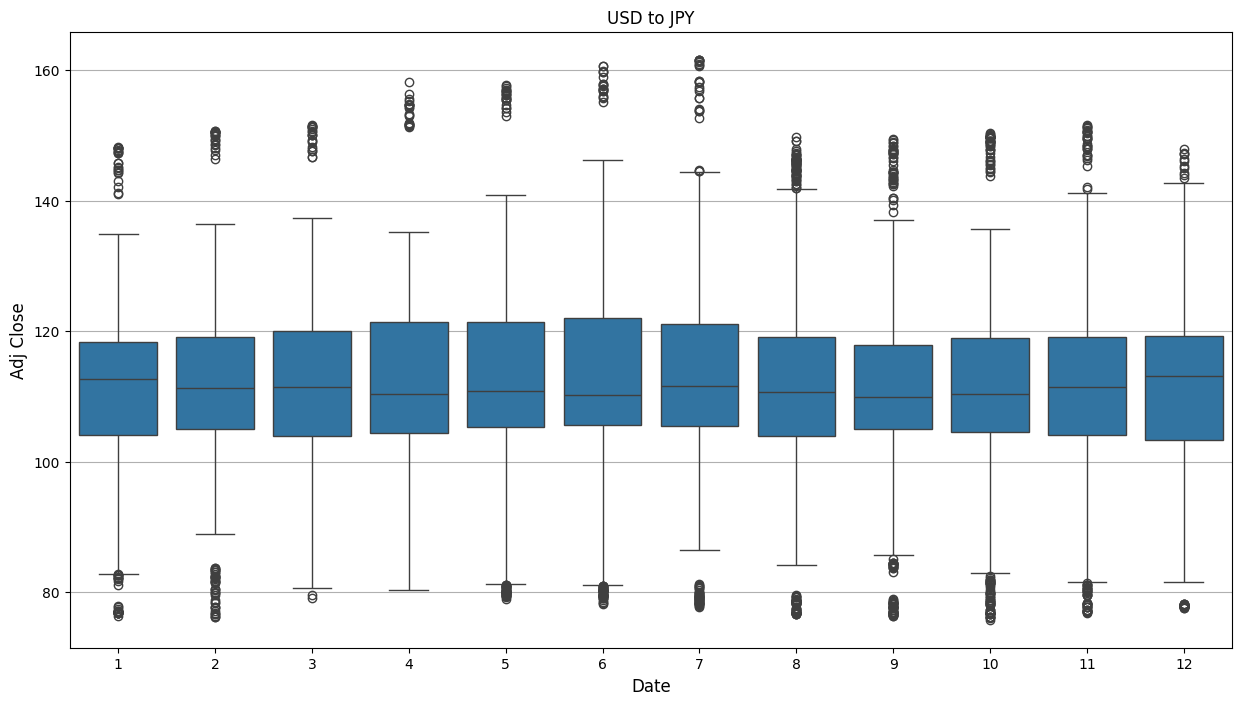

In [12]:
# Plotting Adj Close price against Month
plt.figure(figsize=(15,8))
plt.grid(True)
plt.title('USD to JPY')
sns.boxplot(x=usd_jpy_df['Month'], y=usd_jpy_df['Adj Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adj Close', fontsize=12)
plt.show()

ACF and PACF Plot


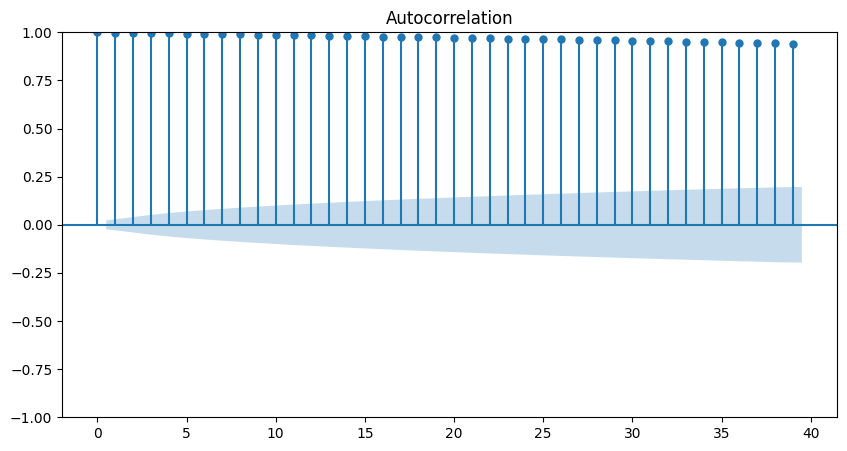

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(10,5))
plot_acf(usd_jpy_df['Adj Close'])
print()


We can see autocorrelation until 40 lag values

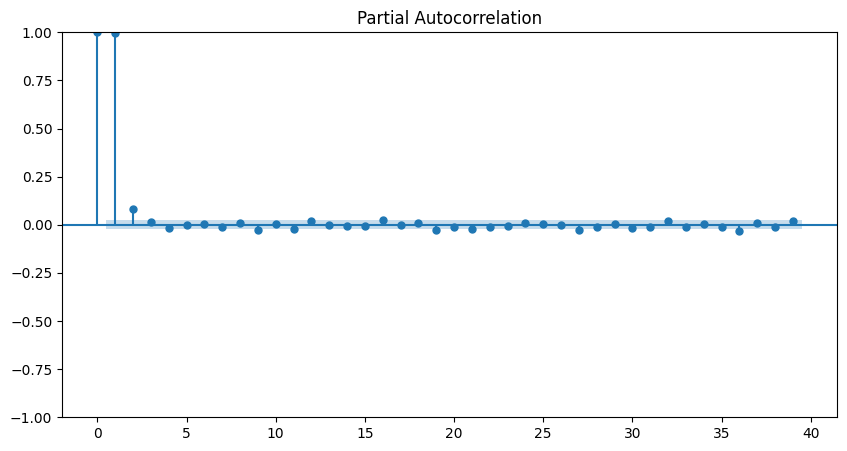

In [14]:
#Partial auto-correlation shows only few lag values are actually correlated.
plt.rc("figure", figsize=(10,5))
plot_pacf(usd_jpy_df['Adj Close'])
print()

📙 4. Price forecasting¶


In [15]:
data = usd_jpy_df['Adj Close'].values
data

array([114.18000031, 113.5       , 113.87999725, ..., 144.        ,
       144.51600647, 143.9750061 ])

In [16]:
data.shape

(7218,)

In [17]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  5774
Shape of Train and Test data:  5774 1444


In [18]:
# split a univariate sequence into supervised learning [Input and Output]
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)-1-n_steps):
        #sequence=10, n_steps=3
        end_ix = i + n_steps
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [19]:
lag = 3  # Empirically we have choosen
n_features = 1

In [20]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [21]:
train_X

array([[114.18000031, 113.5       , 113.87999725],
       [113.5       , 113.87999725, 114.25      ],
       [113.87999725, 114.25      , 113.94999695],
       ...,
       [109.96099854, 109.94100189, 109.97399902],
       [109.94100189, 109.97399902, 109.7559967 ],
       [109.97399902, 109.7559967 , 109.80999756]])

In [22]:
train_y

array([114.25      , 113.94999695, 111.73999786, ..., 109.7559967 ,
       109.80999756, 110.40000153])

In [23]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (5770, 3) (5770,)
Shape of test_X and test_y:  (1440, 3) (1440,)


In [24]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [25]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (5770, 3, 1) (5770,)
Shape of test_X and test_y:  (1440, 3, 1) (1440,)


In [26]:
#4.4 Define Model
'''from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# define model
model = Sequential()
model.add(LSTM(16, activation='relu', return_sequences=False, input_shape=(lag, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()'''

"from keras.models import Sequential\nfrom keras.layers import LSTM\nfrom keras.layers import Dense\n# define model\nmodel = Sequential()\nmodel.add(LSTM(16, activation='relu', return_sequences=False, input_shape=(lag, n_features)))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')\nmodel.summary()"

In [27]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((3, 1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(train_X, train_y, epochs = 25, batch_size=8, verbose=1, validation_split= 0.1)

Epoch 1/25


2024-09-05 15:17:05.360770: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


650/650 [==============================] - 1s 838us/step - loss: 181.9386 - val_loss: 0.4920
Epoch 2/25
650/650 [==============================] - 0s 672us/step - loss: 1.1859 - val_loss: 0.4920
Epoch 3/25
650/650 [==============================] - 1s 818us/step - loss: 1.1654 - val_loss: 0.8731
Epoch 4/25
650/650 [==============================] - 0s 629us/step - loss: 1.1916 - val_loss: 0.5008
Epoch 5/25
650/650 [==============================] - 0s 696us/step - loss: 1.2348 - val_loss: 0.6342
Epoch 6/25
650/650 [==============================] - 0s 660us/step - loss: 1.2431 - val_loss: 0.4836
Epoch 7/25
650/650 [==============================] - 0s 696us/step - loss: 1.2425 - val_loss: 0.5098
Epoch 8/25
650/650 [==============================] - 0s 636us/step - loss: 1.2813 - val_loss: 0.5009
Epoch 9/25
650/650 [==============================] - 0s 634us/step - loss: 1.2747 - val_loss: 0.7468
Epoch 10/25
650/650 [==============================] - 0s 623us/step - loss: 1.2683 - val_l

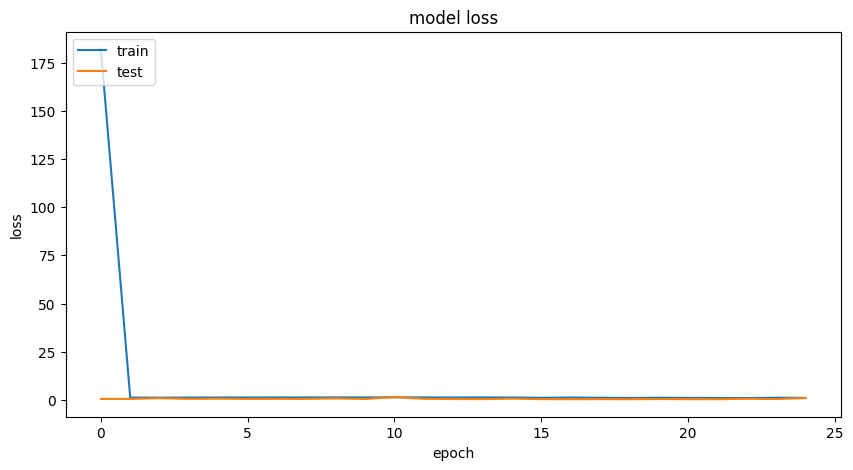

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

45/45 [==============================] - 0s 777us/step
Shape of train and test predict:  (5770, 1) (1440, 1)


In [31]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(train_y, train_predict)
test_score = measure_rmse(test_y, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

Train and Test RMSE:  1.1329953740955265 1.2648833428852253


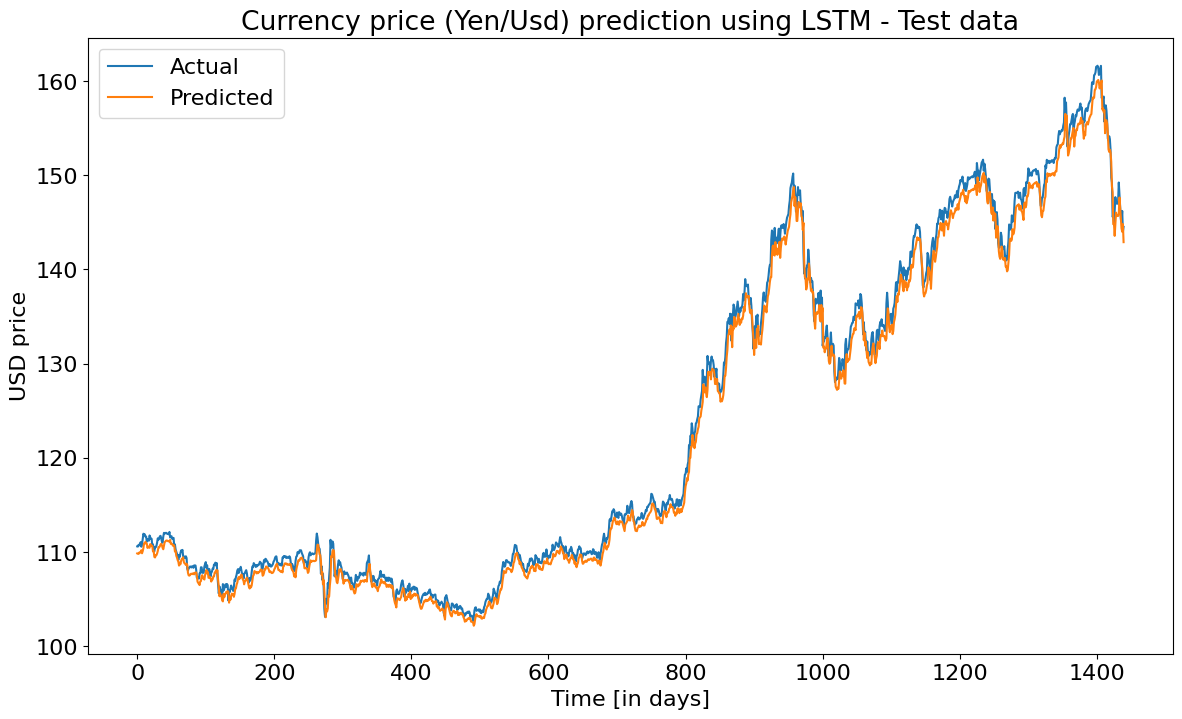

In [32]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(test_y, label = 'Actual')
plt.plot(test_predict, label = 'Predicted')
plt.xlabel('Time [in days]')
plt.ylabel('USD price')
plt.title('Currency price (Yen/Usd) prediction using LSTM - Test data')
plt.legend()
plt.show()

In [33]:
import numpy as np
# Assume 'model' is your trained model and 'scaler' is your data scaler

# Get the last sequence of known values
last_sequence = test_X[-1]  # Shape: (sequence_length, num_features)

# Prepare to store predictions
future_predictions = []

# Number of days to predict
num_future_days = 5

for _ in range(num_future_days):
    # Reshape the last sequence for prediction
    input_data = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

    # Make prediction
    predicted_value = model.predict(input_data)

    # Append prediction to our list
    future_predictions.append(predicted_value[0, 0])

    # Update last_sequence by removing the oldest entry and adding the new prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = predicted_value
    print(last_sequence)


1/1 [==============================] - 0s 9ms/step
[[146.20199585]
 [144.        ]
 [142.89108276]]
1/1 [==============================] - 0s 8ms/step
[[144.        ]
 [142.89108276]
 [142.00654602]]
1/1 [==============================] - 0s 8ms/step
[[142.89108276]
 [142.00654602]
 [140.99565125]]
1/1 [==============================] - 0s 8ms/step
[[142.00654602]
 [140.99565125]
 [139.99716187]]
1/1 [==============================] - 0s 7ms/step
[[140.99565125]
 [139.99716187]
 [139.02987671]]


In [36]:
# Sep 6, 2024  to Sep 10, 2024
future_predictions= [144.8149, 144.70709, 144.21967, 144.2897, 144.11491]

Text(0, 0.5, 'USD/YEN')

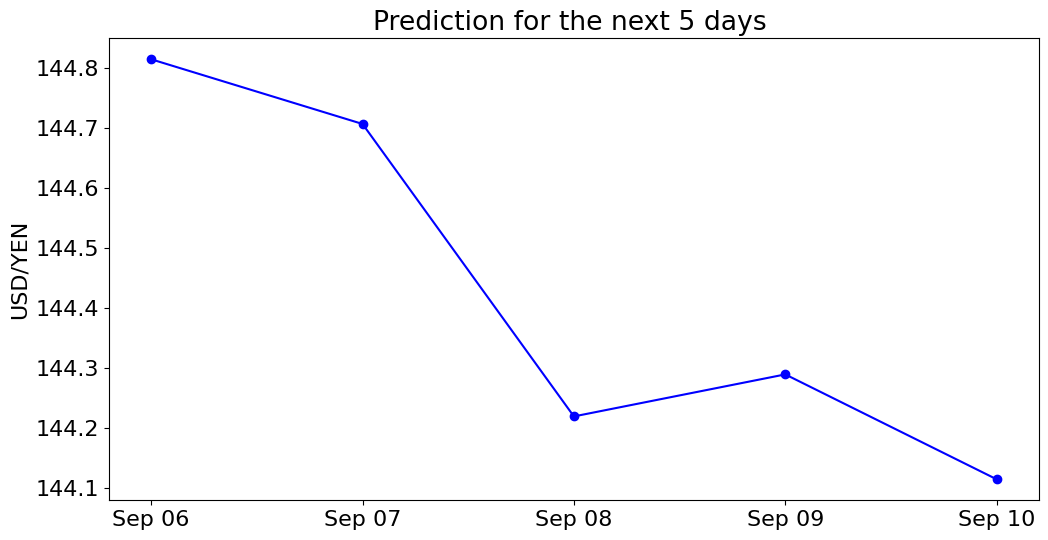

In [38]:
from datetime import datetime, timedelta
# Define the dates for the predictions
start_date = datetime(2024, 9, 6).date()
dates = [start_date + timedelta(days=i) for i in range(5)]
formatted_dates = [date.strftime('%b %d') for date in dates]
plt.figure(figsize=(12, 6))
plt.plot(formatted_dates, future_predictions, marker='o', linestyle='-', color='b', label='Predictions')
plt.title("Prediction for the next 5 days ")
plt.ylabel('USD/YEN')